# Lab - Movie (Graph) Analysis [Lecture 28]


In [336]:
import json
import networkx as nx
import matplotlib.pyplot as plt

plt.style.use('ggplot')


## Step 1: Ingest the Data

In [337]:
def read_movie_data(file_path):
    movie_list = []
    with open(file_path, 'r', errors='ignore') as file:
        for line in file:
            line = line.strip()
            try:
                movie = json.loads(line)
                movie_list.append(movie)
            except json.JSONDecodeError:
                continue
    return movie_list


# Replace 'movies.json' with the actual path to your data file.
movies = read_movie_data('imdbClean.json')


In [338]:
import re


def filter_us_movies(movie_list):
    usa_pattern = re.compile(r'USA', re.IGNORECASE)
    us_movies = [movie for movie in movie_list if 'Country' in movie and usa_pattern.search(
        movie['Country'])]
    return us_movies


us_movies = filter_us_movies(movies)


In [339]:
total_movies = len(movies)
us_movies_count = len(us_movies)

print(f"Total number of movies: {total_movies}")
print(f"Number of US movies: {us_movies_count}")


Total number of movies: 115056
Number of US movies: 46592


## Step 2: Kevin Bacon

### Which actor has been in the most movies?

In [340]:
actors_graph = nx.Graph()


def build_actors_graph(actors_graph, movie_list):
    for movie in movie_list:
        actors = movie['Actors'].split(', ')
        # Filter out any actor named 'N/A' from the actors list
        actors = [actor for actor in actors if actor != 'N/A']
        for actor in actors:
            actors_graph.add_node(actor)
            for costar in actors:
                if actor != costar:
                    actors_graph.add_edge(actor, costar)


# Assuming you have already defined `us_movies` list containing movie data
build_actors_graph(actors_graph, us_movies)

# Get the number of nodes and edges in the graph
num_nodes = actors_graph.number_of_nodes()
num_edges = actors_graph.number_of_edges()

# Print the results
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")


Number of nodes: 49739
Number of edges: 201326


In [341]:

# Calculate the degree of each node in the graph (number of costars)
actors_degrees = actors_graph.degree()

# Find the maximum degree (most edges)
max_degree = max(actors_degrees, key=lambda x: x[1])[1]

# Find all actors with the maximum degree (most edges)
actors_with_most_edges = [actor for actor,
                          degree in actors_degrees if degree == max_degree]

print(f"The actors with the most costars (edges) are:")
for actor in actors_with_most_edges:
    print(f"{actor} - Number of costars: {max_degree}")


The actors with the most costars (edges) are:
John Wayne - Number of costars: 278


In [342]:
def count_actor_movies(movie_list):
    actor_movies = {}
    for movie in movie_list:
        actors = movie['Actors'].split(', ')
        actors = [actor for actor in actors if actor != 'N/A']
        for actor in actors:
            if actor not in actor_movies:
                actor_movies[actor] = 0
            actor_movies[actor] += 1
    return actor_movies


count_actor_movies = count_actor_movies(us_movies)


In [343]:
def actors_with_most_movies(actor_movies_counts):
    max_movies = max(actor_movies_counts.values())
    actors_with_max_movies = [
        actor for actor, count in actor_movies_counts.items() if count == max_movies]
    return actors_with_max_movies


actors_with_max_movies = actors_with_most_movies(count_actor_movies)

print("Actors with the most movies:")
for actor in actors_with_max_movies:
    print(f"{actor} was in {count_actor_movies[actor]} movies")


Actors with the most movies:
Oliver Hardy was in 264 movies


In [344]:
# Get the total number of movies John Wayne appeared in
john_wayne_movies_count = count_actor_movies.get('John Wayne', 0)

print(f"John Wayne was in {john_wayne_movies_count} movies")

actors_in_movies_less_than_john_wayne = [
    actor for actor, count in count_actor_movies.items() if count <= john_wayne_movies_count]

print(f"There are {len(actors_in_movies_less_than_john_wayne)} actors who were in less movies than John Wayne")

# Calculate the percentage of actors who were in less movies than John Wayne
total_actors_count = len(count_actor_movies)
percentage_less_than_john_wayne = (
    len(actors_in_movies_less_than_john_wayne) / total_actors_count) * 100

print(f"This represents {percentage_less_than_john_wayne:.2f}% of all actors.")


John Wayne was in 160 movies
There are 49734 actors who were in less movies than John Wayne
This represents 99.99% of all actors.


Ranking by the number of costars, John Wayne holds the No.1 position, indicating that he has collaborated with a significant number of actors in the movie industry. While he might not have appeared in the most movies overall, John Wayne's impressive network of costars still places him above 99.9% of all actors. This finding highlights the strength of using the number of costars as a good proxy for estimating the number of movies an actor has been in. 

### How many movies was Kevin Bacon in? How many costars has he had?

In [345]:
kevin_bacon_movies_count = count_actor_movies['Kevin Bacon']

number_of_costars = actors_graph.degree('Kevin Bacon')

print(f"Kevin Bacon was in {kevin_bacon_movies_count} movies.")
print(f"Kevin Bacon had {number_of_costars} costars.")


Kevin Bacon was in 57 movies.
Kevin Bacon had 127 costars.


### What is the median number of costars an actor has had?

The median number of costars an actor has had is: 3


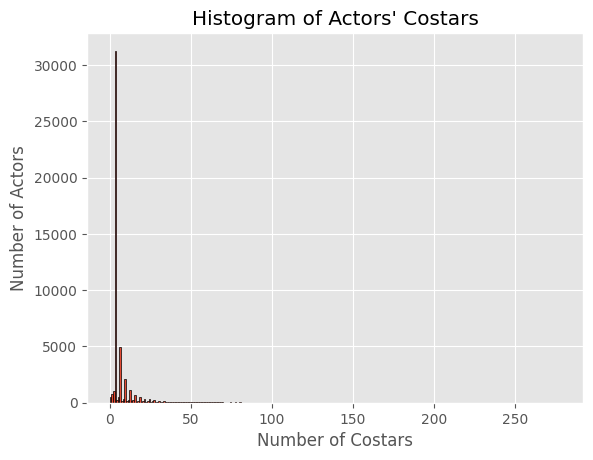

In [346]:

actors_degrees = dict(actors_graph.degree())

degrees_list = list(actors_degrees.values())

sorted_degrees = sorted(degrees_list)

num_actors = len(sorted_degrees)

if num_actors % 2 == 0:
    median_index = num_actors // 2
    median_costars = (
        sorted_degrees[median_index] + sorted_degrees[median_index - 1]) / 2
else:
    median_index = (num_actors - 1) // 2
    median_costars = sorted_degrees[median_index]

print(f"The median number of costars an actor has had is: {median_costars}")

plt.hist(degrees_list, bins=range(min(degrees_list),
         max(degrees_list) + 1, 1), edgecolor='black')
plt.xlabel("Number of Costars")
plt.ylabel("Number of Actors")
plt.title("Histogram of Actors' Costars")
plt.show()


### Is the "6 degrees of separation" from Kevin Bacon theory true? If not, provide counterexamples.

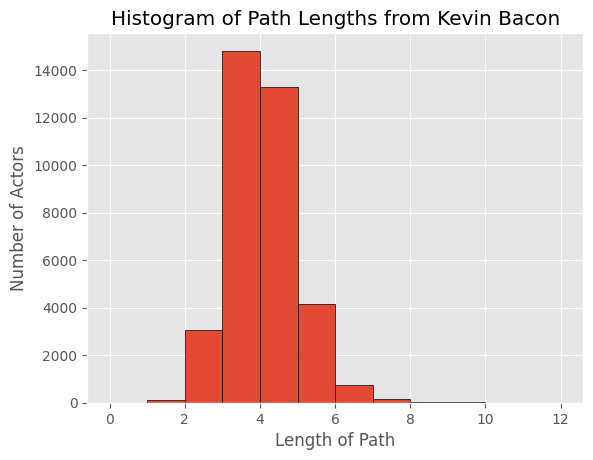

In [347]:

path_lengths = nx.shortest_path_length(actors_graph, source='Kevin Bacon')

path_lengths_list = list(path_lengths.values())

plt.hist(path_lengths_list, bins=range(min(path_lengths_list),
                                       max(path_lengths_list) + 1, 1), edgecolor='black')
plt.xlabel("Length of Path")
plt.ylabel("Number of Actors")
plt.title("Histogram of Path Lengths from Kevin Bacon")
plt.show()


In [348]:
def calculate_percentage(path_lengths_list):
    total_paths = len(path_lengths_list)
    paths_1_to_6 = sum(
        1 for path_length in path_lengths_list if path_length <= 6)
    percentage = (paths_1_to_6 / total_paths) * 100
    return percentage


percentage_of_paths_1_to_6 = calculate_percentage(path_lengths_list)

print(
    f"Percentage of paths from 1 to 6 (inclusive): {percentage_of_paths_1_to_6:.2f}%")


Percentage of paths from 1 to 6 (inclusive): 99.41%


The histogram demonstrates that approximately 99.41% of actors are reachable from Kevin Bacon within 6 steps, providing strong evidence to support the "6 degrees of separation" theory. 

### Step 3: Other Actor Analysis

In [349]:
# Extract the subgraph of people who have costarred with Kevin Bacon
kevin_bacon = 'Kevin Bacon'
kevin_bacon_subgraph = nx.subgraph(actors_graph, list(
    actors_graph.neighbors(kevin_bacon)) + [kevin_bacon])

# Compute node sizes based on the degree in the full graph
node_sizes = [30 * actors_graph.degree(actor)
              for actor in kevin_bacon_subgraph.nodes()]


In [350]:
import matplotlib.colors as mcolors


def draw_subgraph_with_colors(kevin_bacon_subgraph, node_sizes, layout_method):
    
    pos_layout = None
    
    # Create the initial positions using the specified layout method
    if layout_method not in ['circular', 'spring']:
        raise ValueError("Invalid layout_method. Use 'circular' or 'spring'.")

    if layout_method == 'circular':
        pos_layout = nx.circular_layout(kevin_bacon_subgraph)

    if layout_method == 'spring':
        pos_squiggly = nx.spring_layout(
            kevin_bacon_subgraph, pos=pos_layout, k=0.5, iterations=50)

    # Get the degrees of nodes within the subgraph
    node_degrees_colors_map = dict(kevin_bacon_subgraph.degree())

    second_largest_value = sorted(node_degrees_colors_map.values())[-2]
    node_degrees_colors_map[kevin_bacon] = second_largest_value + 1

    # Define a colormap that maps degrees to colors
    cmap = plt.cm.Reds

    # Create a scalar map to map node degrees to the colormap
    scalar_map = plt.cm.ScalarMappable(norm=mcolors.Normalize(
        vmin=min(node_degrees_colors_map.values()), vmax=max(node_degrees_colors_map.values())), cmap=cmap)
    scalar_map.set_array([])  # Empty array to use the full range of colors

    # Draw the subgraph with the squiggly edges and node colors based on degrees
    plt.figure(figsize=(22, 18))
    nx.draw(kevin_bacon_subgraph, with_labels=True, pos=pos_layout, node_size=node_sizes, font_size=10,
            node_color=list(node_degrees_colors_map.values()), cmap=cmap, edge_color='gray', width=0.5)

    # Add a color bar using the scalar map
    cbar = plt.colorbar(scalar_map)
    cbar.set_label("Node Degree")
    plt.title(
        f"Kevin Bacon Subgraph, {layout_method} layout (Nodes Colored by Degree)", fontsize=30)
    plt.show()

/var/folders/2s/zcn_xxg538x7xfw89v6cm33r0000gn/T/ipykernel_24106/2834234899.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(scalar_map)


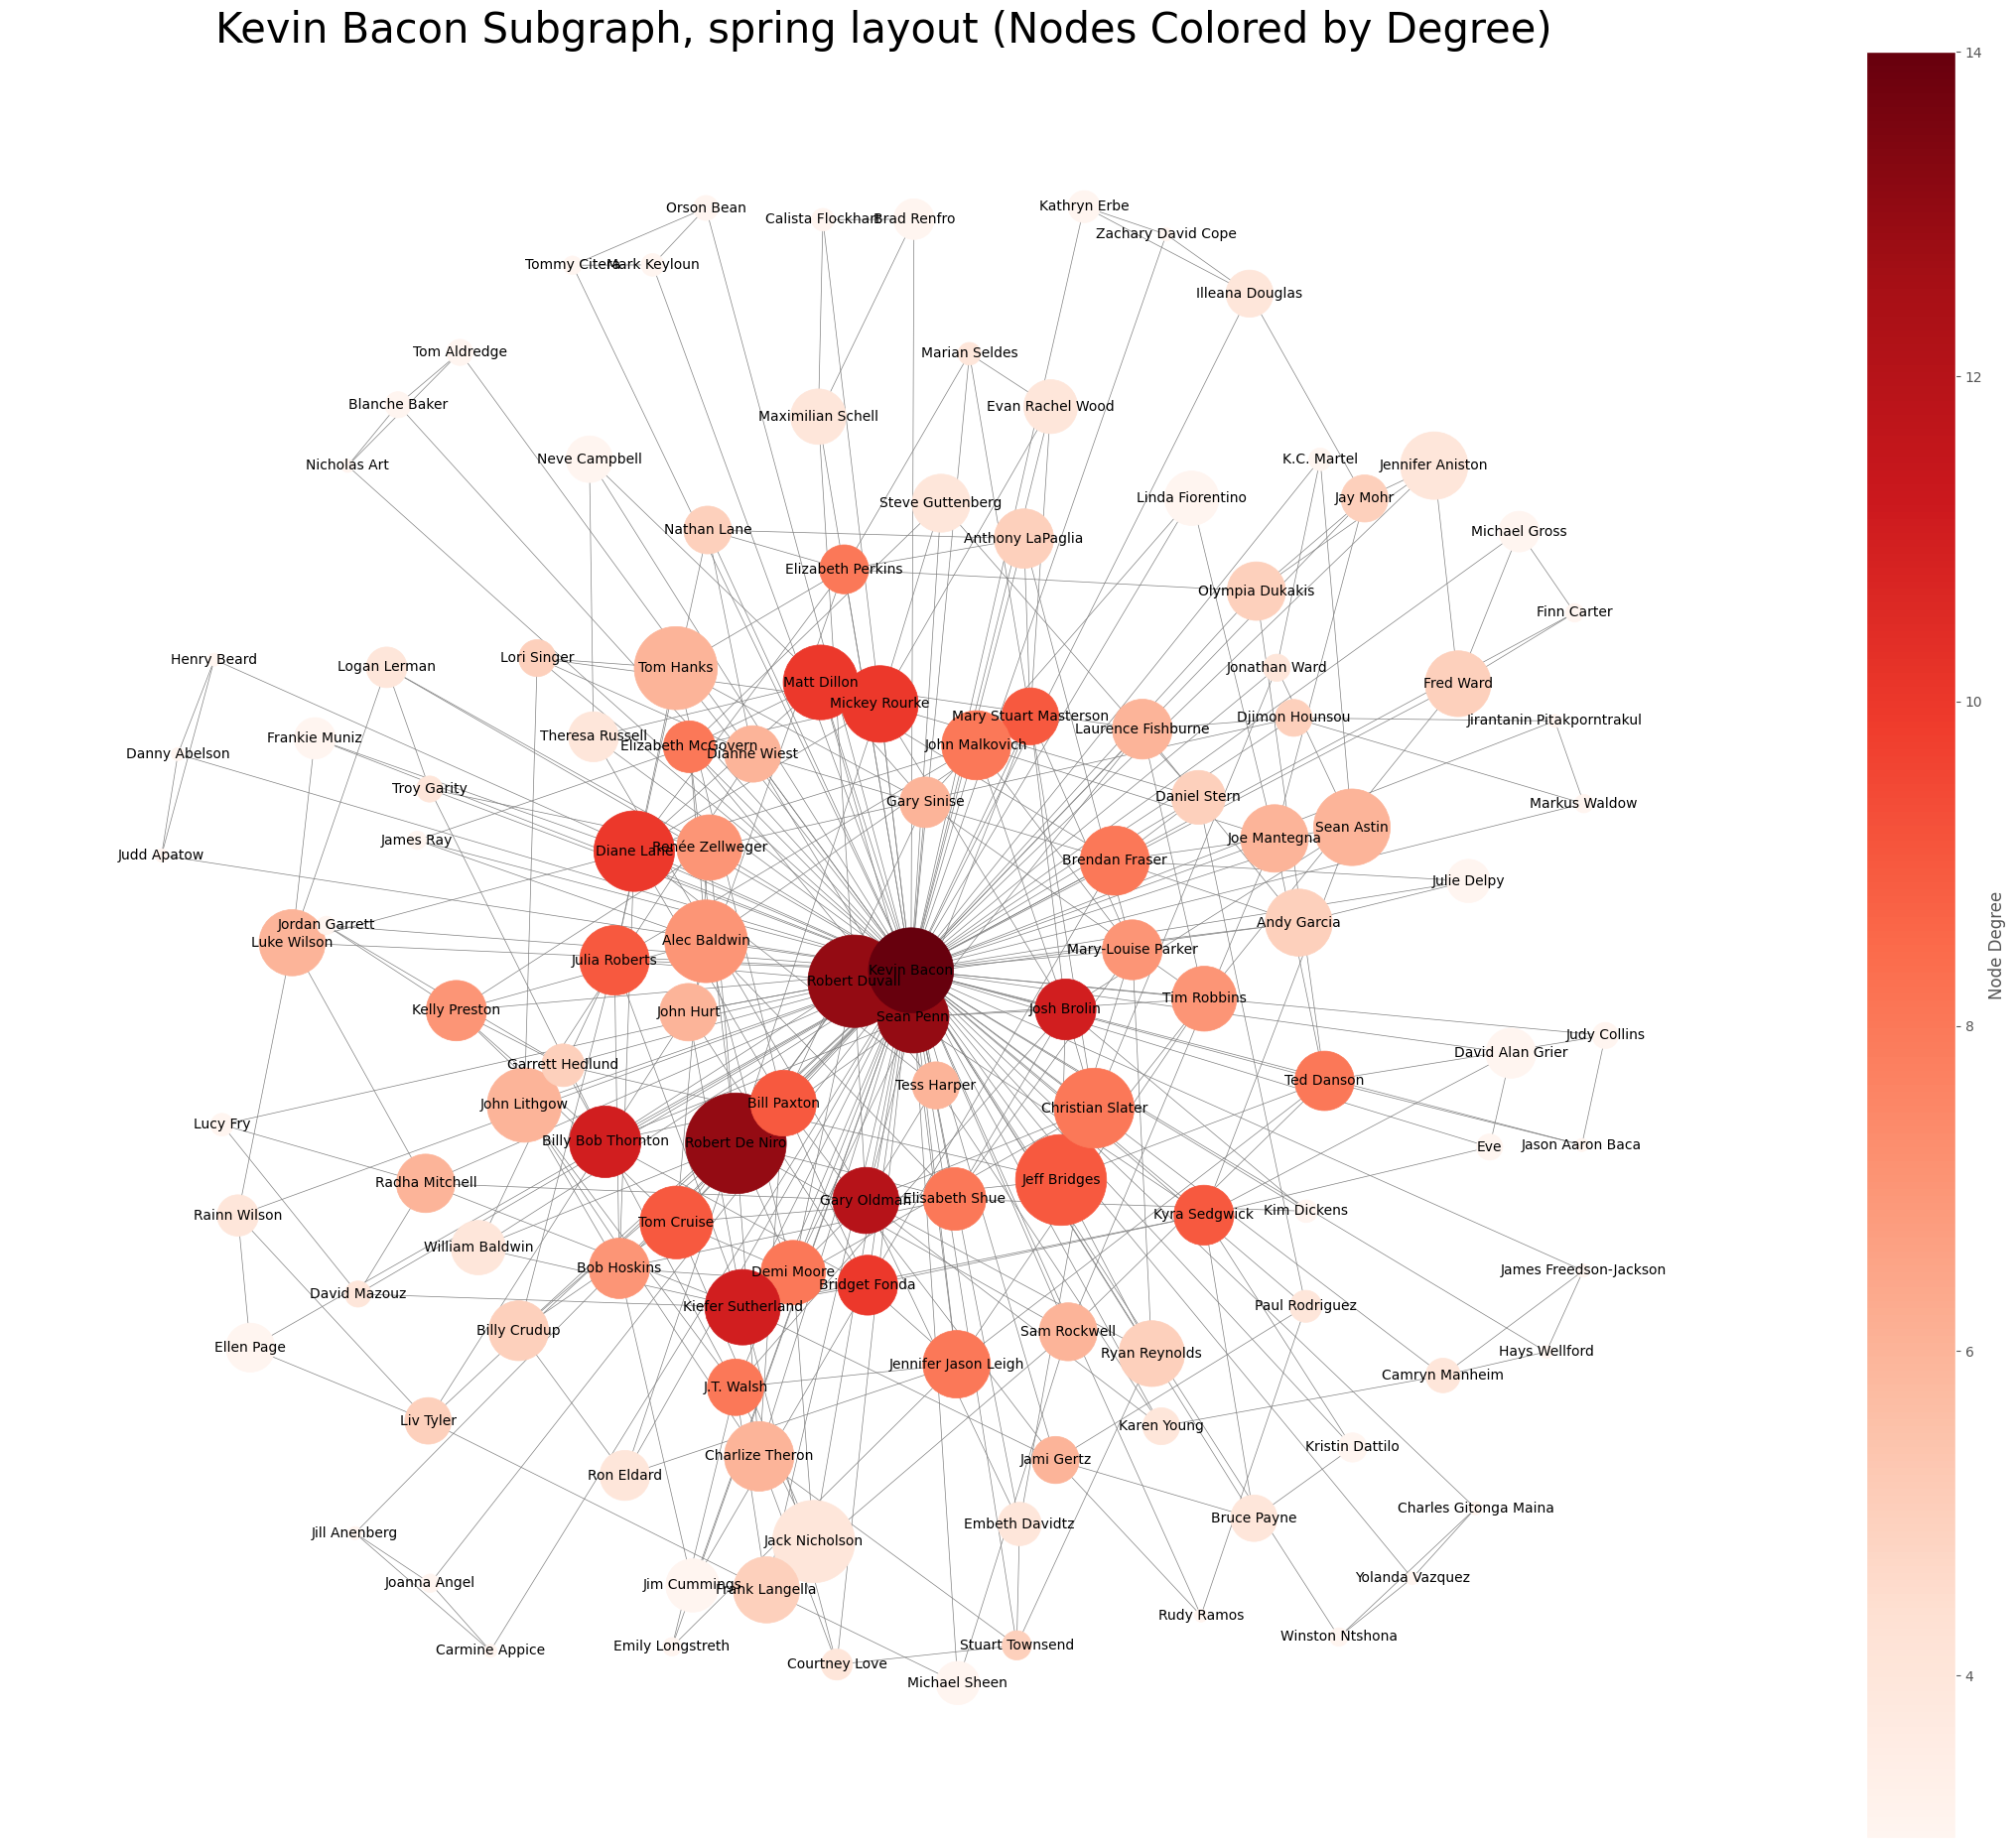

In [351]:
draw_subgraph_with_colors(kevin_bacon_subgraph, node_sizes, 'spring')


/var/folders/2s/zcn_xxg538x7xfw89v6cm33r0000gn/T/ipykernel_24106/2834234899.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(scalar_map)


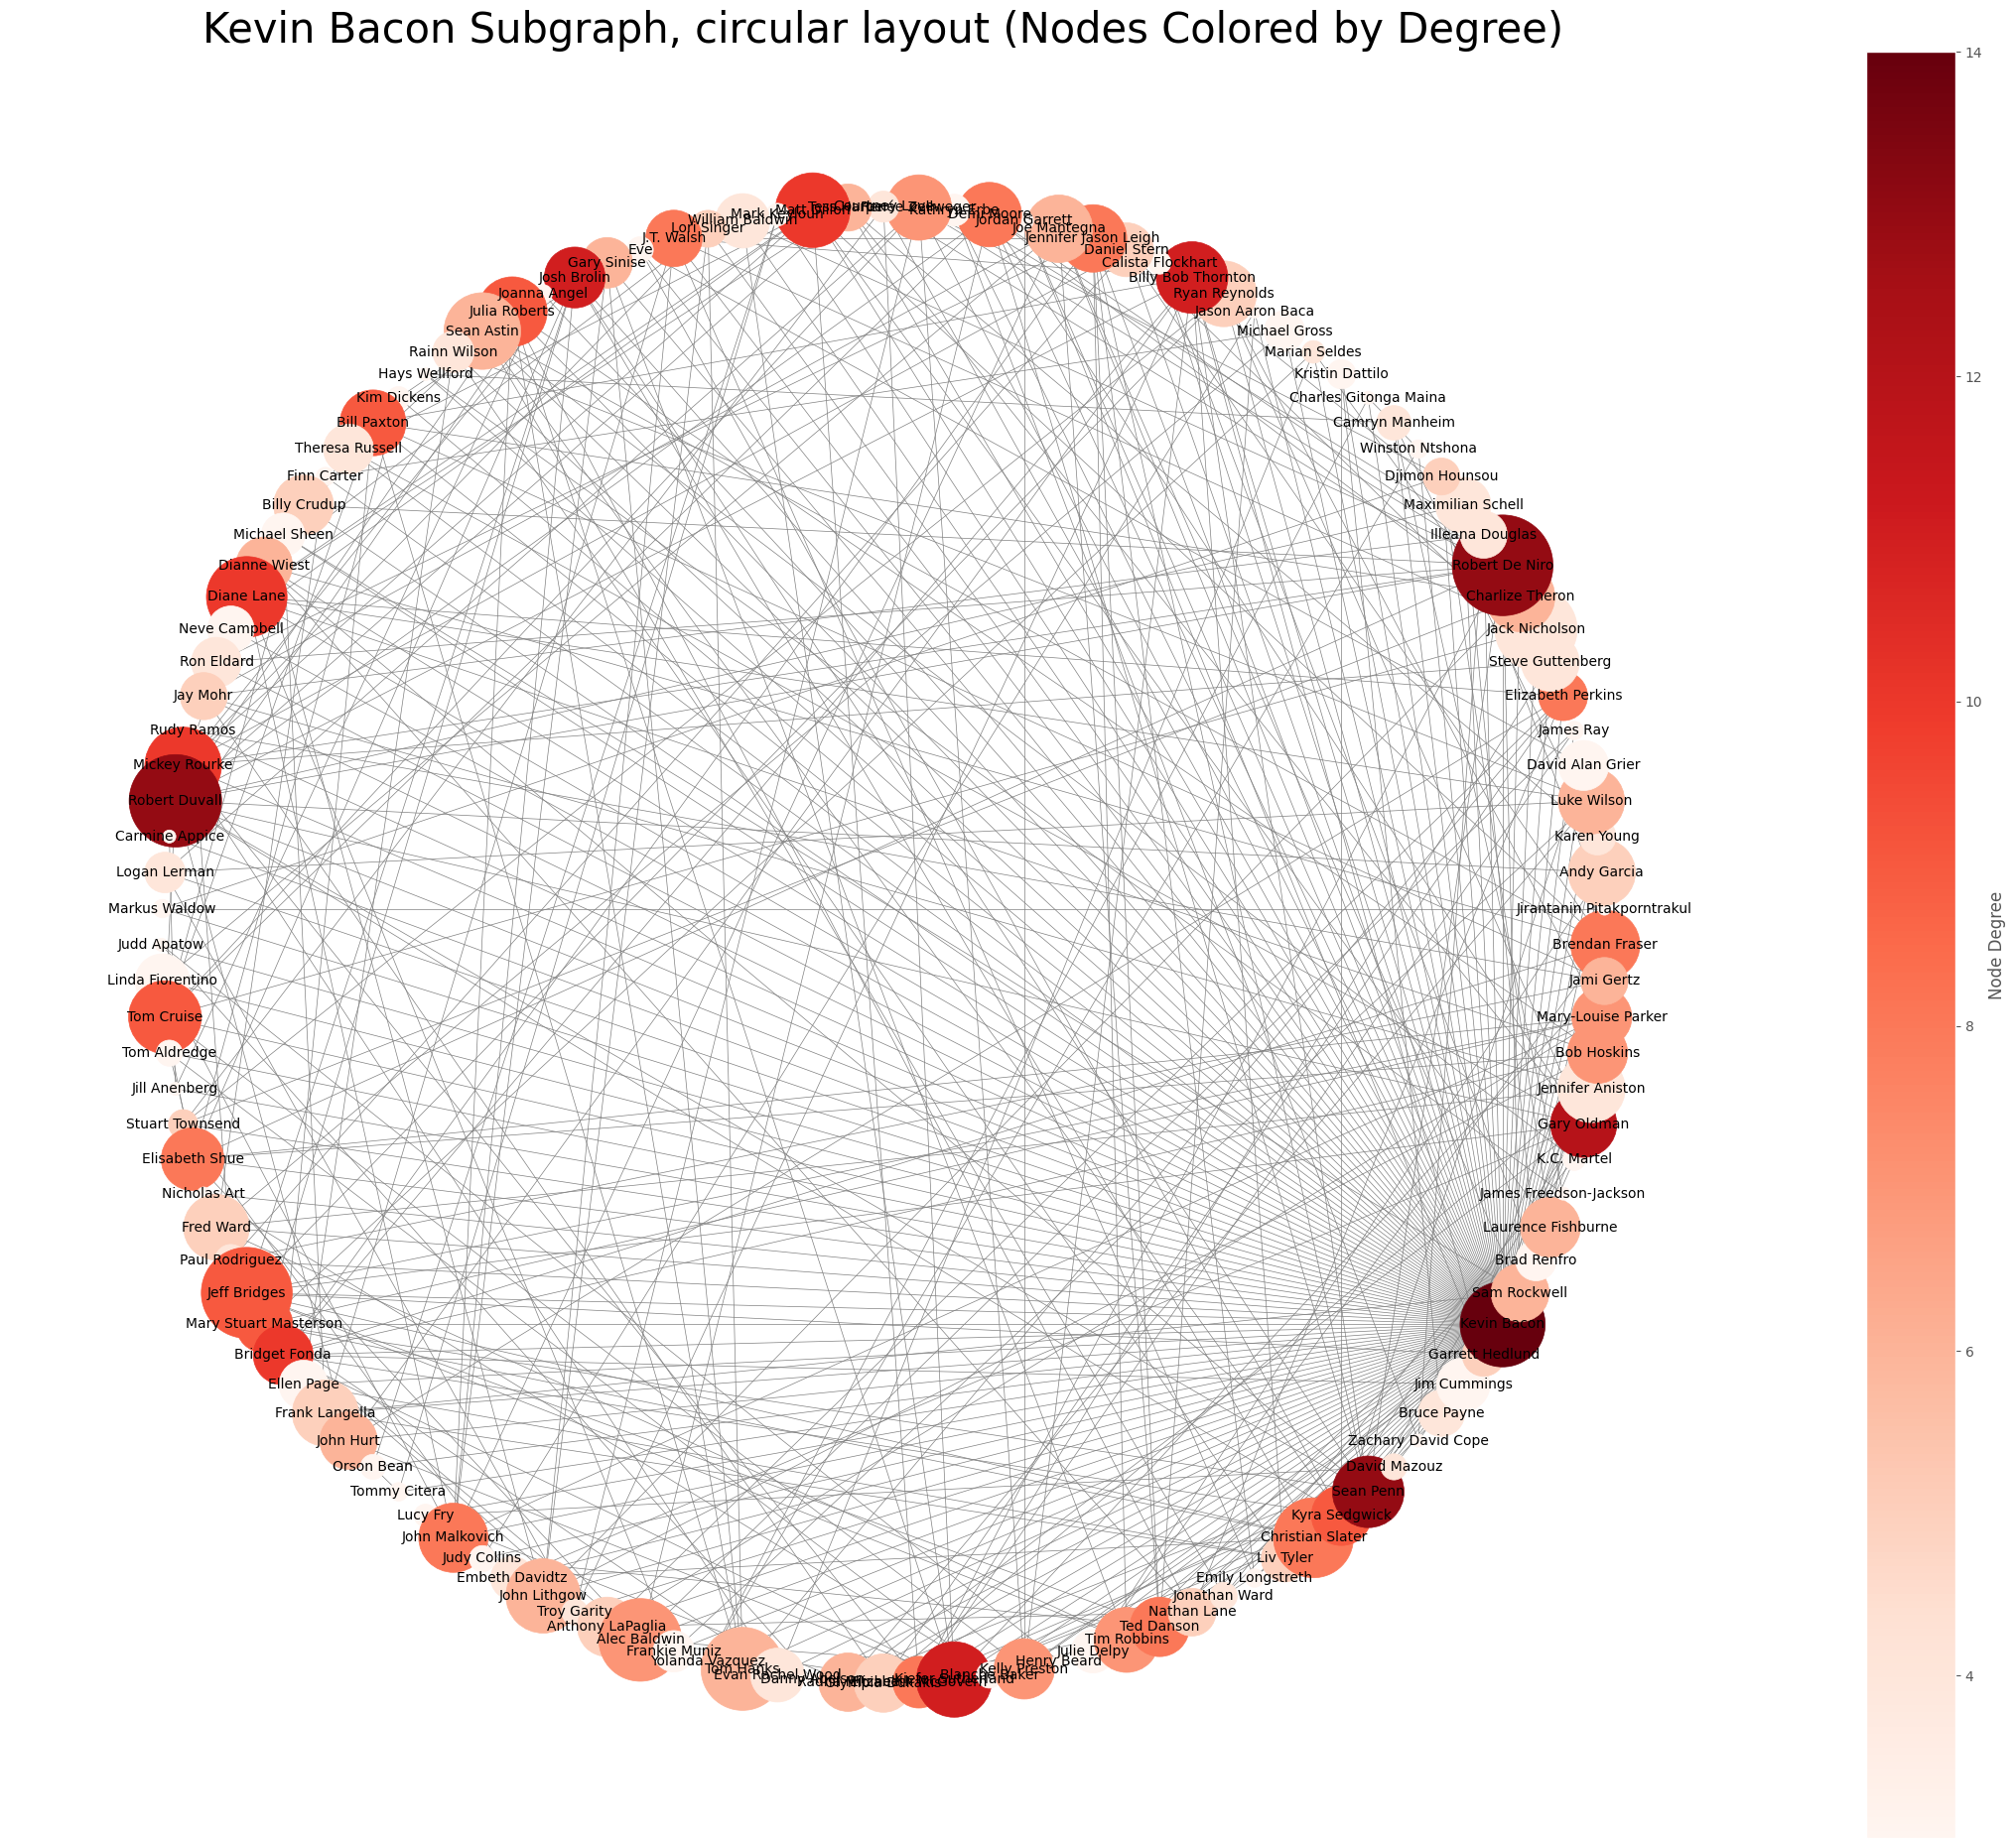

In [352]:
draw_subgraph_with_colors(kevin_bacon_subgraph, node_sizes, 'circular')


In [353]:
# Compute the PageRank of the graph
page_rank_scores = nx.pagerank(actors_graph)

# Sort the actors based on their PageRank scores
sorted_actors_by_pagerank = sorted(
    page_rank_scores.items(), key=lambda x: x[1], reverse=True)

# Print the 5 highest scoring actors
print("Top 5 actors by PageRank:")
for actor, score in sorted_actors_by_pagerank[:5]:
    print(f"{actor}: {score}")

# Print the 5 lowest scoring actors
print("\nBottom 5 actors by PageRank:")
for actor, score in sorted_actors_by_pagerank[-5:]:
    print(f"{actor}: {score}")


Top 5 actors by PageRank:
Oliver Hardy: 0.0003627219646454787
Harry Carey: 0.0003062704324806107
John Wayne: 0.0002845927919705141
Steven Seagal: 0.00027131182777280624
Mickey Rooney: 0.00025806383399703257

Bottom 5 actors by PageRank:
Kathryn Osterman: 3.0402742287793097e-06
Peter Bernuth: 3.0402742287793097e-06
Britt Allcroft: 3.0402742287793097e-06
Paul Goodman: 3.0402742287793097e-06
Oscar Micheaux: 3.0402742287793097e-06


Based on the PageRank results:

1. Top 5 actors: Oliver Hardy, Harry Carey, John Wayne, Steven Seagal, and Mickey Rooney are considered more central and influential in the network of co-starring relationships. These actors have relatively higher PageRank scores, indicating that they have appeared in many movies and have significant connections to other important actors in the graph. They are likely to be well-known and have had successful careers with collaborations spanning across multiple movies.

2. Bottom 5 actors: Kathryn Osterman, Peter Bernuth, Britt Allcroft, Paul Goodman, and Oscar Micheaux have lower PageRank scores, suggesting that they have fewer connections and appear in fewer significant movies. These actors may have had fewer opportunities to work with other influential actors or have been part of less prominent movie collaborations.

The PageRank provides a ranking of actors based on their importance and influence within the movie industry network. It offers insights into the popularity and collaboration patterns of actors. However, it's important to note that the PageRank is just one metric, and the interpretation may vary depending on the specific dataset used and the context of the movie industry. Other factors, such as movie genres, historical significance, and cultural impact.

### Step 4: Star Wars 6 degrees of separation ( US movies only )

In [354]:
star_wars_movies_titles = [movie['Title'] for movie in us_movies if 'Star Wars' in movie['Title']]

print(f"There are {len(star_wars_movies_titles)} Star Wars movies in the dataset.")

for star_wars_movie in star_wars_movies_titles:
    print(star_wars_movie)


There are 20 Star Wars movies in the dataset.
Star Wars: Episode I - The Phantom Menace
Rogue One: A Star Wars Story
Empire of Dreams: The Story of the 'Star Wars' Trilogy
Star Wars: Ewoks - The Haunted Village
Star Wars: The Force Awakens
Saving 'Star Wars'
Star Wars
Robot Chicken: Star Wars
Star Wars: Episode VIII
Star Wars: The Clone Wars
Star Wars: Droids - The Pirates and the Prince
Star Wars: Episode IV - A New Hope
Star Wars: Revelations
Star Wars: Episode II - Attack of the Clones
Star Wars: Episode IV - A New Hope
Lego Star Wars: Revenge of the Brick
Star Wars: Episode III - Revenge of the Sith
Star Wars: Episode IV - A New Hope
Star Wars Gangsta Rap
The Star Wars Holiday Special


In [355]:
merged_star_wars_us_movies = [movie for movie in us_movies if movie['Title'] not in star_wars_movies_titles]

star_wars_movies = [movie for movie in us_movies if 'Star Wars' in movie['Title']]

star_wars_movies_actors = set() 

for movie in star_wars_movies:
    for actor in movie['Actors'].split(', '):
        if actor != 'N/A':
            star_wars_movies_actors.add(actor)

star_wars_movie_actors  = list(star_wars_movies_actors)


star_war_series = {
    'Title': 'Star Wars',
    'Actors': ', '.join(star_wars_movie_actors)
}

merged_star_wars_us_movies.append(star_war_series)


In [356]:
import networkx as nx

def build_movie_actor_graph(movie_list):
    movie_actor_graph = nx.DiGraph()

    for movie in movie_list:
        movie_title = movie['Title']
        movie_actor_graph.add_node(
            movie_title, type='movie')  # Add movies as nodes

        actors = movie['Actors'].split(', ')
        for actor in actors:
            if actor != 'N/A':
                if not movie_actor_graph.has_node(actor):
                    movie_actor_graph.add_node(
                        actor, type='actor')  # Add actors as nodes

                # Add edges between movies and actors with weight 0
                movie_actor_graph.add_edge(movie_title, actor, weight=0)
                # Add edges between actors and movies with weight 1
                movie_actor_graph.add_edge(actor, movie_title, weight=1)

                for another_actor in actors:
                    if another_actor != 'N/A' and another_actor != actor:
                        if not movie_actor_graph.has_node(another_actor):
                            movie_actor_graph.add_node(
                                another_actor, type='actor')

                        # Add edges between actors with weight 1
                        movie_actor_graph.add_edge(
                            actor, another_actor, weight=1)

    return movie_actor_graph


movie_actor_graph = build_movie_actor_graph(merged_star_wars_us_movies)

# Source movie (change this to any movie you want to start from)
source_movie = 'Star Wars'

# Calculate the shortest paths from the source movie to all other movies
shortest_paths = nx.single_source_dijkstra_path_length(
    movie_actor_graph, source=source_movie, weight='weight')

other_movies = [movie['Title'] for movie in merged_star_wars_us_movies if movie['Title'] != source_movie]

shortest_paths = {movie: shortest_paths[movie]
                  for movie in other_movies if movie in shortest_paths}



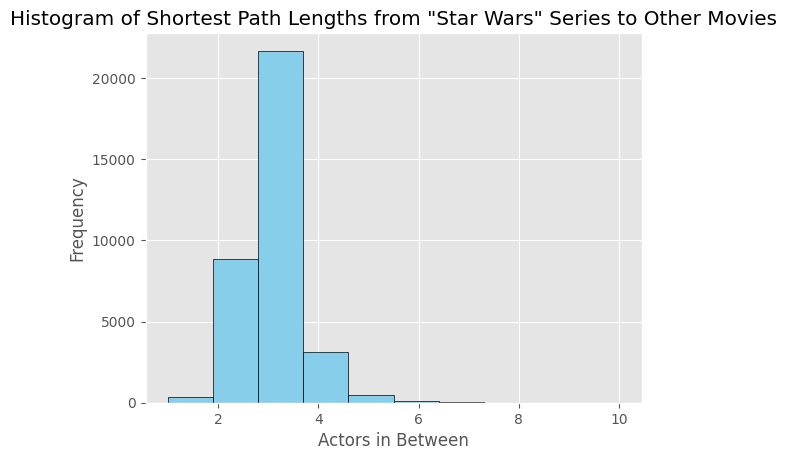

In [357]:
# Get the lengths of the shortest paths as a list
path_lengths = list(shortest_paths.values())

# Plot the histogram
plt.hist(path_lengths, bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Actors in Between')
plt.ylabel('Frequency')
plt.title(
    f'Histogram of Shortest Path Lengths from "{source_movie}" Series to Other Movies')

plt.show()

In [358]:
percentage_of_paths_1_to_6 = calculate_percentage(path_lengths)

print(
    f"Percentage of paths from 1 to 6 (inclusive): {percentage_of_paths_1_to_6:.2f}%")


Percentage of paths from 1 to 6 (inclusive): 99.90%


The histogram demonstrates that approximately 99.90% of movies are reachable from Star War Series within 6 actors, providing strong evidence to support the "6 degrees of separation" theory. 